In [1]:
'''Train a Bidirectional LSTM on the IMDB sentiment classification task.
Output after 4 epochs on CPU: ~0.8146
Time per epoch on CPU (Core i7): ~150s.
'''

from __future__ import print_function
import numpy as np

from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
from keras.datasets import imdb
import nltk.corpus.reader.bnc
import nltk
import glove
import nltk
import numpy as np
import random
import tensorflow as tf
import time
import unittest
import word_stream
import word_utils
from __future__ import unicode_literals
import io
from textblob import Blobber
from textblob_aptagger import PerceptronTagger
from bs4 import BeautifulSoup
import re
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from sklearn import metrics
import imp


Using TensorFlow backend.


In [2]:
actionability_train =  pd.read_csv('~/w210_imwithdata/data/static_data/full_rzst_test_dataset.csv',encoding ='latin-1')
print (actionability_train.columns)
tweet_text_list = actionability_train['tweet'].tolist()

full_tweet_list = []
for tweet in tweet_text_list:
    tweet = re.sub('[!@#$.]', '', tweet)
    tweet += str(' .')
    full_tweet_list.append(tweet)
    
tweet_actionable_list = actionability_train['actionable'].tolist()
tweet_tuples = list(zip(full_tweet_list,tweet_actionable_list))
print (tweet_tuples[:10]) 

Index(['issue', 'action', 'id', 'es_score', 'tweet_timestamp',
       'query_timestamp', 'tweet_user', 'tweet', 'actionable'],
      dtype='object')
[('https://tco/9vAellIc6i - RSS Channel: Colin Kaepernick pledges to donate money fromjersey sales https://tco/mFnw8q7tyl .', 0), ('Please Support kevinsanders23 Baby Bombers and Medicare Donate Here - https://tco/HLliHGEpNF ID=4 .', 1), ('Reminder that the GOP alternative to the Affordable Care Act defunds ppfa _Ù÷_Donate now and show\x89Û_ https://tco/3aWSX3tXBb .', 1), ("Don't forget to donate accordingly to https://tco/pSpQmWIGV1 The AARP spends more than 7 million/yr lobbying fed gvt to protect Medicare .", 1), ("I'm raising money for ACA- Affordable Care Act Fund Click to Donate:  https://tco/9ymuQZLZbc via gofundme .", 1), ('Please Support kevinsanders23 Baby Bombers and Medicare Donate Here - https://tco/szNPbaCXIT ID=5 .', 1), ('ALERT: Violet needs help\r\rShe is at VCA Westlake now with a prolapsed rectum for the third time\r\rDo

In [4]:
tb = Blobber(pos_tagger=PerceptronTagger())

In [3]:
# capture word probabilities
#
# It's necessary to divide each paragraph up into sections with no mistakes and into sections with mistakes...

# Define canonicalize
def canonicalize_words_and_labels(seq, label, errorLabel):
    # Insert <s> at start of sentence
    seq = re.sub(r'([.!?])',r' \1 ', seq.strip())

    # split off commas
    seq = re.sub(r',', r' , ', seq)

    # split off 4 digits from s
    seq = re.sub(r'(\d\d\d\d)s', r' \1 s ', seq)

    # split off "
    seq = re.sub(r'"', r' " ', seq)

    # split off %
    seq = re.sub(r'\%', ' % ', seq)

    # split off \( and \)
    seq = re.sub(r'([\(\)])', r' \1 ', seq)

    # convert can't to cant and won't to wont
    seq = re.sub(r"can't", r' cant ', seq)
    seq = re.sub(r"won't", r' wont ', seq)
    seq = re.sub(r"don't", r' dont ', seq)
    seq = re.sub(r"didn't", r' didnt ', seq)

    # Another other 't gets converted to not
    seq = re.sub(r"\'t\s", r' not ', seq)

    # split off 's
    seq = re.sub(r"\'s", r" 's ", seq)

    # split off ' that is not a 's
    seq = re.sub(r"\'([^s])", r" ' \1", seq)
    seq = re.sub(r"s'\s*", r"s ' ", seq)

    # split off ;
    seq = re.sub(r'(;)', r' \1 ', seq)

    # split at hyphen (-)
    seq = re.sub(r'(\-)', r' \1 ', seq)

    # split at colon
    seq = re.sub(r':', r' : ', seq)

    # split words by white space:
    splitWords = re.split(r'\s+', seq.strip())

    # lower-case all words
    splitWords = [Word.lower() for Word in splitWords]

    # Adjust labels, errors to have the same length as the number of words in the sequence...
    lenSeq = len(splitWords)
    seqLabels = [label] * lenSeq
    errorLabels = [errorLabel] * lenSeq
    return splitWords, seqLabels, errorLabels


wordCorpus = []         # list of every word in the corpus, splitting off punctuation as separate tokens
wordLabels = []         # list of Ylabels (0=="noErr", 1=="Err")
errorLabels = []        # list of error types (0-5)
correctWordCorpus = []  # corpus with only "good" and "corrected" words, should have no misspellings

        
for tweet,actionability in tweet_tuples:
    myWords, myLabels, myErrors = canonicalize_words_and_labels(tweet, label=actionability, errorLabel=actionability)
    wordCorpus.extend(myWords)
    wordLabels.extend(myLabels) 
    errorLabels.extend(myErrors)
    correctWordCorpus.extend(myWords)

        
# Check 
print ("Length of Corpus in words is " +  str((len(wordCorpus))))
print (str(len(wordLabels)) + " binary labels")
print (str(len(errorLabels)) + " error code labels" )



Length of Corpus in words is 341483
341483 binary labels
341483 error code labels


In [5]:
### ASSIGN PART OF SPEECH TAGS WHERE POSSIBLE
### USE 'UNK' TOKEN IN SITUATIONS WHERE TAGGER IGNORED
posTags =[]

text = ' '.join(wordCorpus)
tagged = tb(text)
tag_list = [x[1] for x in tagged.tags]
word_list = [x[0].lower() for x in tagged.tags]
    
        
tags_used = 0
for w,word in enumerate(wordCorpus):
    try:
        index = word_list[tags_used:].index(word) + tags_used
        tag = tag_list[index]
        tags_used += 1
        posTags.append(tag)
    except:
        tag = 'UNK'
        posTags.append(tag)

In [6]:
### CREATE ERROR CODES
pos_list = list(set(posTags))
pos_codes = [i for i,code in enumerate(pos_list)]

### CREATE DICT FOR LOOKUP CODE TO NAME
pos_dict = dict(zip(pos_codes, pos_list))
# print "Part of Speech Code to Label Lookup"
# print pos_dict
# print

### CREATE REVERSE DICT FOR LOOKUP NAME TO CODE
pos_reverse_dict = dict(zip(pos_list, pos_codes))
# print "Part of Speech Label to Code Lookup"
# print pos_reverse_dict

### Create list of pos numerical IDs for each word in our Corpus
posIDs = [ pos_reverse_dict[POS] for POS in posTags]


In [7]:
import vocabulary; imp.reload(vocabulary)
import utils; imp.reload(utils)
import itertools
import rnnlm; imp.reload(rnnlm)


# Word processing functions
def c_canonicalize_digits(word):
    if any([c.isalpha() for c in word]): return word
    word = re.sub("\d", "DG", word)
    if word.startswith("DG"):
        word = word.replace(",", "") # remove thousands separator
    return word

def c_canonicalize_word(word, wordset=None, digits=True):
    word = word.lower()
    if digits:
        if (wordset != None) and (word in wordset): return word
    word = c_canonicalize_digits(word) # try to canonicalize numbers
    if (wordset == None) or (word in wordset): return word
    else: return "<unk>" # unknown token

def c_canonicalize_words(words, **kw):
    return [c_canonicalize_word(word, **kw) for word in words]


def c_build_vocab(corpus, V=10000):
    # token_feed = (utils.canonicalize_word(w) for w in corpus.words())
    # token_feed = (utils.canonicalize_word(w) for w in corpus)
    vocab = vocabulary.Vocabulary(corpus, size=V)
    return vocab

def c_get_sents(corpus):
    '''Simply return the already-created list of list of sentences for our corpus...'''
    # Sentences = re.findall(r'[^.?!]+[.?!]', ' '.join(corpus))
    # Now split each sentence in Sentences into a list of tokens
    # Sentences = [Sent.split() for Sent in Sentences]
    # Sentences = np.array(Sentences, dtype=object)
    return sentsCorpus

def c_get_train_test_sents(Sents, Labels, POS, ErrLabels, split=0.8, shuffle=0):
    """Get train and test sentences."""
    #
    # Create list of sentence lists from corpus
    sentences = np.array(Sents)
    labels = np.array(Labels)
    posIDs = np.array(POS)
    errIDs = np.array(ErrLabels)
    
    # In order to work with shuffling, tuple-ize the lists within the list of lists
    listOfTupes = list(zip(sentences, labels, posIDs, errIDs))
    

    fmt = (len(sentences), sum(map(len, sentences)))
#     print "Loaded %d sentences (%g tokens)" % fmt

    if shuffle:
        rng = np.random.RandomState(shuffle)
        rng.shuffle(listOfTupes)  # in-place
    # unroll...
    unZipped = list(zip(*listOfTupes))
    sentences = unZipped[0]
    labels = unZipped[1]
    posIDs = unZipped[2]
    errIDs = unZipped[3]

    train_frac = split
    split_idx = int(train_frac * len(sentences))
    train_sentences = sentences[:split_idx]
    test_sentences = sentences[split_idx:]
    train_labels = labels[:split_idx]
    test_labels = labels[split_idx:]
    train_pos = posIDs[:split_idx]
    test_pos = posIDs[split_idx:]
    train_errIDs = errIDs[:split_idx]
    test_errIDs = errIDs[split_idx:]
    #
    fmt = (len(train_sentences), sum(map(len, train_sentences)))
    print ("Training set: %d sentences (%d tokens)" % fmt)
    fmt = (len(test_sentences), sum(map(len, test_sentences)))
    print ("Test set: %d sentences (%d tokens)" % fmt)
    print ()
    #
    fmt = (len(train_labels), sum(map(len, train_labels)))
    print ("Training set: %d labels (%d tokens)" % fmt)
    fmt = (len(test_labels), sum(map(len, test_labels)))
    print ("Test set: %d labels (%d tokens)" % fmt)
    print ()
    #
    fmt = (len(train_pos), sum(map(len, train_pos)))
    print ("Training set: %d POS labels (%d tokens)" % fmt)
    fmt = (len(test_pos), sum(map(len, test_pos)))
    print ("Test set: %d POS labels (%d tokens)" % fmt)
    print ()
    #
    fmt = (len(train_errIDs), sum(map(len, train_errIDs)))
    print ("Training set: %d error ID labels (%d tokens)" % fmt)
    fmt = (len(test_errIDs), sum(map(len, test_errIDs)))
    print ("Test set: %d error ID labels labels (%d tokens)" % fmt)
    print ()
    #
    return train_sentences, test_sentences, train_labels, test_labels, train_pos, test_pos, train_errIDs, test_errIDs

def c_flatten(list_of_lists):
    """Flatten a list-of-lists into a single list."""
    return list(itertools.chain.from_iterable(list_of_lists))

def c_preprocess_sentences(sentences, vocab):
    # words = ["<s>"] + utils_flatten(s + ["<s>"] for s in sentences)
    words = c_flatten(s for s in sentences)
    # words = [c_canonicalize_word(w, wordset=vocab.word_to_id) for w in words]
    return np.array(vocab.words_to_ids(words))

def c_preprocess_labels(Labels):
    flatLabels = c_flatten(Label for Label in Labels)
    # words = [utils_canonicalize_word(w, wordset=vocab.word_to_id) for w in words]
    return np.array(flatLabels)

def c_load_corpus(corpus, split=0.8, V=10000, shuffle=0):
    """Load a named corpus and split train/test along sentences."""
    # corpus = inCorpus
    vocab = c_build_vocab(corpus, V)
    train_sentences, test_sentences = c_get_train_test_sents(corpus, split, shuffle)
    train_ids = c_preprocess_sentences(train_sentences, vocab)
    test_ids = c_preprocess_sentences(test_sentences, vocab)
    return vocab, train_ids, test_ids

  
def splitby(pattern, sentenceStack):
    """
    Split by a pattern function 
    This is much like re.split() regular expression function but can operate on other objects besides input strings.
    pattern:        a function applied to each element in the stack, xs.
    sentenceStack:  the stack list of (word,label) tuples in our corpus.
    """

    currentSentence = []
    for Tuple in sentenceStack:
    # If Tuple word is not an end of sentence punctuation,
        if pattern(Tuple):
            # Append the tuple to the current sentence
            currentSentence.append(Tuple)
        else:
            break

    return currentSentence, sentenceStack[len(currentSentence):] 
  
  
def ispunct(x):
    return x == "." #or x == "!" or x == "?"


def sentences(xs):
    results = []
  
    # Iterate through corpus tuples ('word', 0) tuple-by-tuple until all sentences are exhausted.
    while True:
        # Spit out next sentence in xs and new xs with sentence's words popped off
        sentence, xs = splitby(lambda x: not ispunct(x[0]), xs)

        # Pop off top (punctuation character) from corpus stack and put onto the end of the current sentence to which
        # ...it belongs
        if len(xs) >= 1:
            sentence.append(xs[0])
            xs = xs[1:]

        # Add the current sentence (list of (word, label) tuples) to the results list
        results.append(sentence)

        # Exit while loop when sentence stack is empty.
        if not xs:
            break

    # Return the results list of lists split by punctuation
    return results  
  

def unzip(xs):
    # unzip leverages zip() on a list of tuples, resulting in a list of two lists:
    # ...list( [ tuple1[0], tuple2[0],...],
    #          [ tuple1[1], tuple2[1]],...])
    return list(zip(*xs))

### ASSIGN SIZE OF VOCABULARY
V = 10000
# vocab, train_ids, test_ids = load_corpus("brown", split=0.8, V=V, shuffle=42)

# Construct vocabulary, train_words, test_words, train_labels, test_labels

# Recall:
## wordCorpus = list of words
## wordLabels = list of labels

# Create tuples of word strings, wordLabels (0/1 for nonError/Error), POS, and ErrorType
corpusTuples = list(zip(wordCorpus, wordLabels, posIDs, errorLabels))
ss = sentences(corpusTuples)

# print ss

sentsCorpus = [] # List of lists divided by sentence endings [.!?]
sentsLabels = [] # List of lists of labels matching sentsCorpus
sentsPOS = [] # List of lists of POS matching words in sentsCorpus
sentsErrLabels = [] # List of lists of types of errors matching words in sentsCorpus

for sentence in ss:
    unzipped = list(unzip(sentence))
    sentsCorpus.append(list(unzipped[0]))
    sentsLabels.append(list(unzipped[1]))
    sentsPOS.append(list(unzipped[2]))
    sentsErrLabels.append(list(unzipped[3]))


V = 10000

# Build vocabulary
vocab = c_build_vocab(correctWordCorpus, V=V)

type(vocab)

# Generate training and test words and labels
trainWords, testWords, trainListY, testListY, trainPOS, testPOS, trainErrTypes, testErrTypes = c_get_train_test_sents(Sents=sentsCorpus, 
                                                                                                              Labels=sentsLabels, 
                                                                                                              POS=sentsPOS, 
                                                                                                              ErrLabels=sentsErrLabels, 
                                                                                                              split=0.8, 
                                                                                                              shuffle=42)


Training set: 13307 sentences (273705 tokens)
Test set: 3327 sentences (67778 tokens)

Training set: 13307 labels (273705 tokens)
Test set: 3327 labels (67778 tokens)

Training set: 13307 POS labels (273705 tokens)
Test set: 3327 POS labels (67778 tokens)

Training set: 13307 error ID labels (273705 tokens)
Test set: 3327 error ID labels labels (67778 tokens)



In [8]:
y_train = np.array([max(listY) for listY in trainListY])
y_test = np.array([max(listY) for listY in testListY])


In [9]:
# Convert trainWords, testWords to ids:
train_ids = []
test_ids =[]

for sentence in trainWords:
    train_ids.append(vocab.words_to_ids(sentence))
    
x_train = np.array(train_ids)


for sentence in testWords:
    test_ids.append(vocab.words_to_ids(sentence))
    
x_test = np.array(test_ids)

# all_ids = c_preprocess_sentences(np.array([ wordCorpus ]) , vocab)
# print len(train_ids)
# print len(test_ids)

# trainY = c_preprocess_labels(trainListY)
# testY = c_preprocess_labels(testListY)

# train_posids = c_preprocess_labels(trainPOS)
# test_posids = c_preprocess_labels(testPOS)

In [11]:
# train_ids[:10]

In [53]:


max_features = 20000
# cut texts after this number of words
# (among top max_features most common words)
maxlen = 40
batch_size = 32

# print('Loading data...')
# (x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)
# print(len(x_train), 'train sequences')
# print(len(x_test), 'test sequences')


In [54]:

print("Pad sequences (samples x time)")
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)
print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
y_train = np.array(y_train)
y_test = np.array(y_test)


Pad sequences (samples x time)
x_train shape: (13307, 20)
x_test shape: (3327, 20)


In [55]:

model = Sequential()
model.add(Embedding(max_features, 128, input_length=maxlen))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile('adam', 'binary_crossentropy', metrics=['accuracy'])

print('Train...')
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=4,
          validation_data=[x_test, y_test])

Train...
Train on 13307 samples, validate on 3327 samples
Epoch 1/4
13307/13307 [==============================] - 57s - loss: 0.1554 - acc: 0.9487 - val_loss: 0.1076 - val_acc: 0.9612

In [56]:
predictions = model.predict(x_test)


In [57]:
test_preds = list(predictions.flatten())

Populating the interactive namespace from numpy and matplotlib


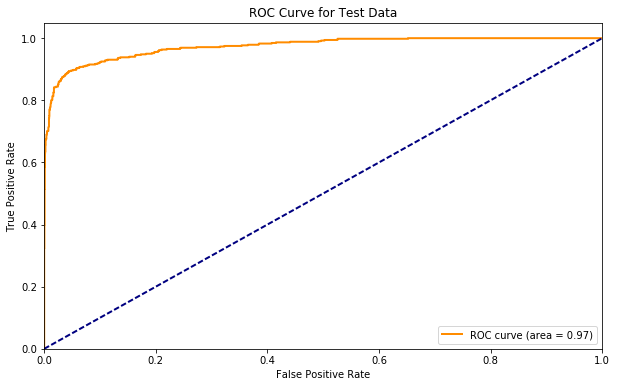

In [58]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)

fpr, tpr, thresholds = metrics.roc_curve(y_test, test_preds)
roc_auc = metrics.auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curve for Test Data')
plt.show()

In [59]:
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()



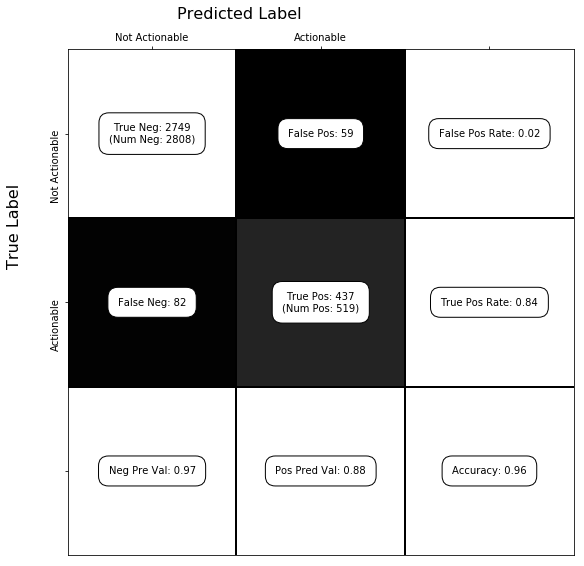

In [60]:
threshold = .6
y_pred = [1 if x > threshold else 0 for x in test_preds]
C = metrics.confusion_matrix(y_test,y_pred)
show_confusion_matrix(C, ['Not Actionable', 'Actionable'])

In [64]:
# Define canonicalize for real world data
def canonicalize_real_world_words(seq):
    # Insert <s> at start of sentence
    seq = re.sub(r'([.!?])',r' \1 ', seq.strip())

    # split off commas
    seq = re.sub(r',', r' , ', seq)

    # split off 4 digits from s
    seq = re.sub(r'(\d\d\d\d)s', r' \1 s ', seq)

    # split off "
    seq = re.sub(r'"', r' " ', seq)

    # split off %
    seq = re.sub(r'\%', ' % ', seq)

    # split off \( and \)
    seq = re.sub(r'([\(\)])', r' \1 ', seq)

    # convert can't to cant and won't to wont
    seq = re.sub(r"can't", r' cant ', seq)
    seq = re.sub(r"won't", r' wont ', seq)
    seq = re.sub(r"don't", r' dont ', seq)
    seq = re.sub(r"didn't", r' didnt ', seq)

    # Another other 't gets converted to not
    seq = re.sub(r"\'t\s", r' not ', seq)

    # split off 's
    seq = re.sub(r"\'s", r" 's ", seq)

    # split off ' that is not a 's
    seq = re.sub(r"\'([^s])", r" ' \1", seq)
    seq = re.sub(r"s'\s*", r"s ' ", seq)

    # split off ;
    seq = re.sub(r'(;)', r' \1 ', seq)

    # split at hyphen (-)
    seq = re.sub(r'(\-)', r' \1 ', seq)

    # split at colon
    seq = re.sub(r':', r' : ', seq)
    
    seq = re.sub('[!@#$.]', '', seq)
    seq += str(' .')

    # split words by white space:
    splitWords = re.split(r'\s+', seq.strip())

    # lower-case all words
    splitWords = [Word.lower() for Word in splitWords]

    return splitWords

In [66]:
#### YOU CAN PLAY AROUND WITH PREDICTING SETENCES HERE 

sentence = canonicalize_real_world_words('I love @Alex Jones. Donald Trump is great. Make America Great Again. #MAGA')
sentence_ids = np.array(vocab.words_to_ids(sentence))
sentences = []
sentences.append(sentence_ids)

sentence_padded = sequence.pad_sequences(sentences, maxlen=maxlen)
sentence_padded = np.array(sentence_padded)
print(sentence_padded.shape)

model.predict(sentence_padded)

(1, 20)


array([[ 0.00012306]], dtype=float32)